<a href="https://colab.research.google.com/github/CyTusSi1ver1197/Fundamental-ML/blob/debugging/Copy_of_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mini-Project for Fundamentals of Machine Learning Course
In this study, facial expression recognition was performed on the face images from the Facial Expression Recognition Challenge (FER2013) dataset.

One motivation for representation learning is that learning algorithms can design features more effectively and efficiently than humans can. However, this challenge does not explicitly require entries to use representation learning. The dataset, assembled from the internet, is designed for facial expression classification.

The data consists of grayscale images of faces, each measuring 48x48 pixels. The faces have been automatically aligned to be roughly centered and occupy a similar area within each image. The task is to categorize each face based on the emotion expressed, assigning it to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The dataset contains a total of 35,887 examples.

## 1. Prerequisite
This section provides some basic steps for accessing and visualizing the dataset.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# import warnings
# warnings.filterwarnings("ignore")

In [2]:
def parse_data(data: pd.DataFrame):
    """
    Reads input dataframe then return arrays of images and labels
    """
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image

    return image_array, image_label

In [3]:
def show_img(images: np.ndarray, labels: np.ndarray):
    """
    Visualize images and labels respectively
    """
    _, axarr=plt.subplots(nrows=2, ncols=5, figsize=(18, 9))
    axarr=axarr.flatten()
    for idx, label in enumerate(labels[:10]):
        axarr[idx].imshow(images[idx], cmap='gray')
        axarr[idx].set_xticks([])
        axarr[idx].set_yticks([])
        axarr[idx].set_title("Label:{}".format(label))

In [4]:
# If using gg Colab  ## ctrl + /  to comment or uncomment
import gdown
gdown.download('https://drive.google.com/uc?/export=download&id=1sgyyTTgklZDFosHDSbpkSu76OXAIm4C5')
df = pd.read_csv("./icml_face_data.csv")

#df = pd.read_csv("../data/icml_face_data.csv")
df.head()

Downloading...
From (original): https://drive.google.com/uc?/export=download&id=1sgyyTTgklZDFosHDSbpkSu76OXAIm4C5
From (redirected): https://drive.google.com/uc?%2Fexport=download&id=1sgyyTTgklZDFosHDSbpkSu76OXAIm4C5&confirm=t&uuid=c4c53793-12bb-430a-81e6-3ae3a3dd87d5
To: /content/icml_face_data.csv
100%|██████████| 301M/301M [00:05<00:00, 59.3MB/s]


,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [27]:
# Function to convert string representation of list to a list of numbers
def str_to_num_list(s):
    # Remove brackets and split the string by space, then convert to integers
    return [int(num) for num in s.strip('[]').split(' ')]


# Apply the function to the 'array_data' column
df['pixels'] = df['pixels'].apply(str_to_num_list)

In [28]:
df_expand = df['pixels'].apply(pd.Series)

df = pd.concat([df.drop('pixels', axis=1), df_expand], axis=1)

df.head()

,emotion,0,1,2,3,4,5,6,7,8,...,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
0,0,70,80,82,72,58,58,60,63,54,...,159,182,183,136,106,116,95,106,109,82
1,0,151,150,147,155,148,133,111,140,170,...,105,108,95,108,102,67,171,193,183,184
2,2,231,212,156,164,174,138,161,173,182,...,104,138,152,122,114,101,97,88,110,152
3,4,24,32,36,30,32,23,19,20,30,...,174,126,132,132,133,136,139,142,143,142
4,6,4,0,0,0,0,0,0,0,0,...,12,34,31,31,31,27,31,30,29,30


The ```emotion``` column contains a numeric code ranging from 0 to 6, inclusive, for the emotion expressed by the image. The "pixels" column contains a string surrounded in quotes for each image.

In [6]:
## parsing data here
images, labels = parse_data(df)


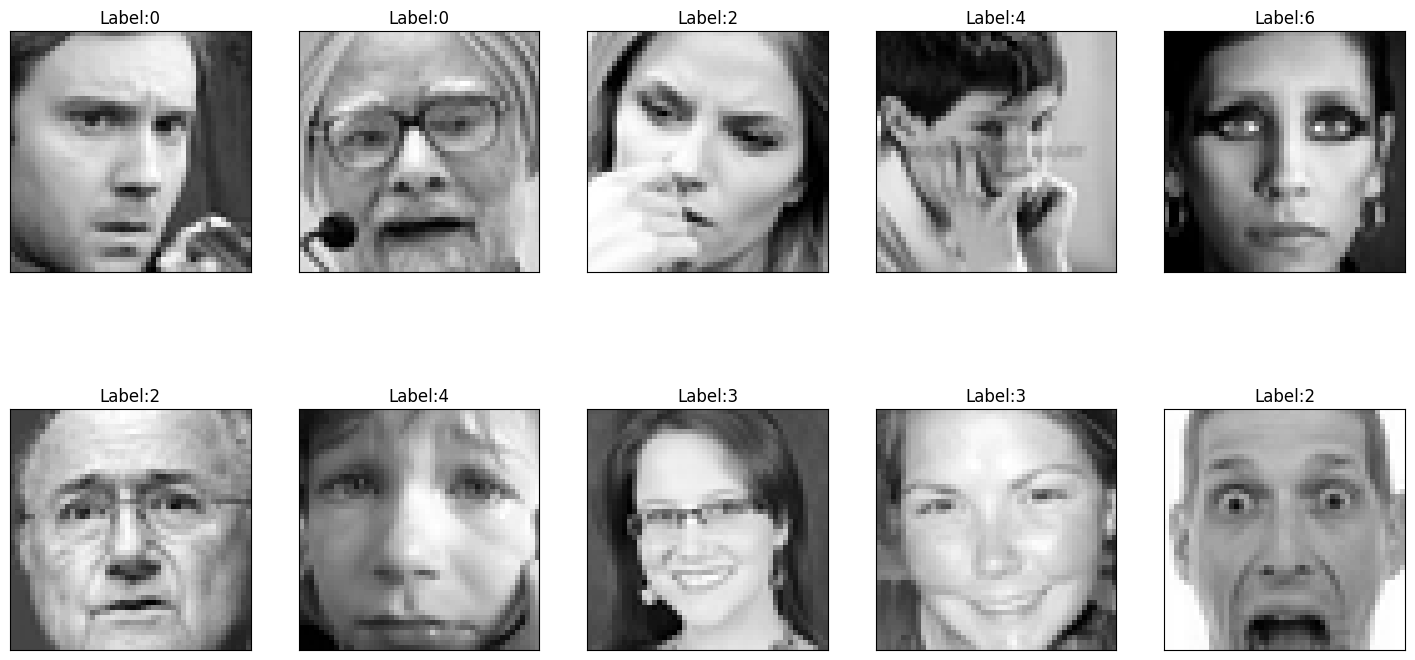

In [7]:
## showing images here
show_img(images, labels)

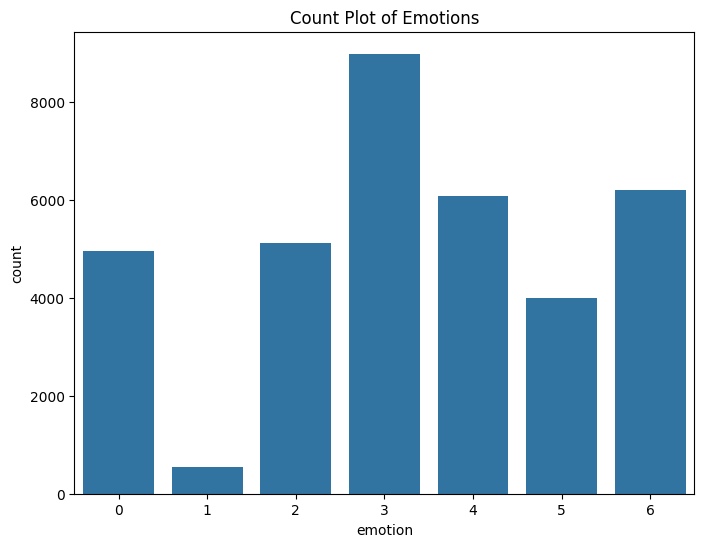

In [8]:
# Initialize the plot
plt.figure(figsize=(8, 6))

# Create the count plot
sns.countplot(x='emotion', data=df)

# Add a title
plt.title('Count Plot of Emotions')

# Show the plot
plt.show()

## 2. Principle Component Analysis

Unsupervised learning can be further categorized into two main tasks: data transformation and clustering. In this study, we will focus on data transformation using unsupervised learning techniques. These techniques aim to modify the data to make it easier for computers and humans to analyze and understand.

One of the most common applications of unsupervised data transformation is dimensionality reduction. This process reduces the number of features (dimensions) in the data. When the data has a high number of features, it can be computationally expensive and difficult to analyze. Dimensionality reduction techniques help to overcome these challenges.

Principal Component Analysis (PCA) is a popular technique for dimensionality reduction. It transforms the data into a new set of features called principal components (PCs). These PCs are ordered by their importance, capturing the most significant variations in the data. By selecting a subset of the most informative PCs, we can achieve a significant reduction in data size while preserving the essential information for analysis.

Question 1: Can you visualize the data projected onto two principal components? (2 points)

In [9]:
## Step 1: Reshape images to 2D-array
flattened_images = images.reshape(images.shape[0], -1)

print(flattened_images.dtype)

len(flattened_images[0])

float64


2304

In [10]:
## Step 2: Unit vector scaling image data by divde to 255: [0-255] -> [0-1]
flattened_images = flattened_images / 255.0

In [11]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca=PCA(n_components=2)
# pca.fit(images) ## modify images' array to the appropriate shape

## Step 3: Create principal components
pca_data = pca.fit(flattened_images)

In [12]:
X_data = pca.transform(flattened_images)

In [13]:
scatter_df = pd.DataFrame(X_data[:,:2], columns=['PC 1', 'PC 2'])
scatter_df['emotion'] = df['emotion'].values

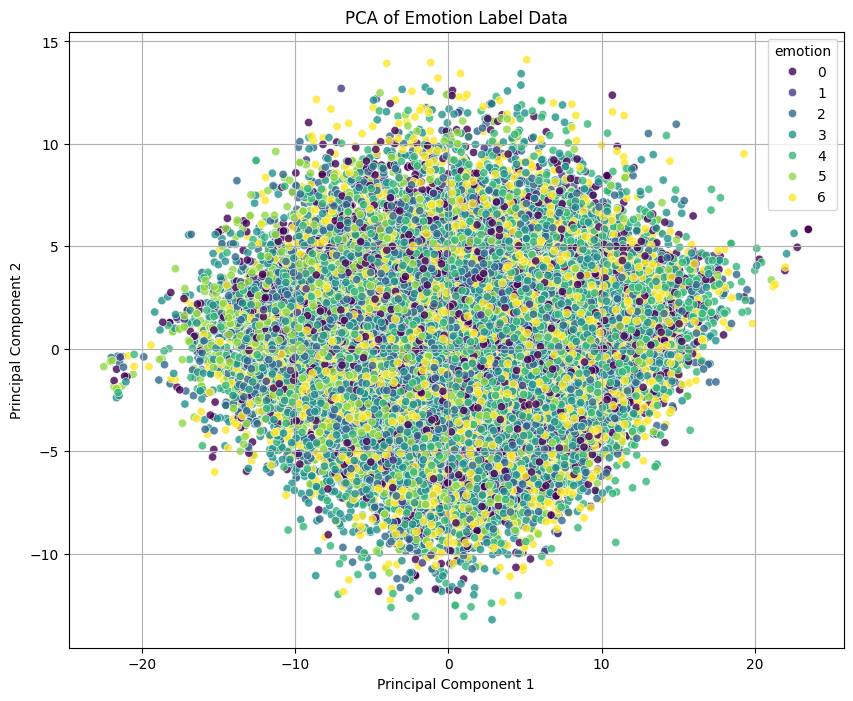

In [14]:
# Plot the results using seaborn
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC 1', y='PC 2', hue='emotion', palette='viridis', data=scatter_df, legend='full', alpha=0.8)
plt.title('PCA of Emotion Label Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()

In [15]:
## transform for visualizing here
# images_pca=pca.transform(images) ## modify images' array to the appropriate shape
# images_pca.shape

Question 2: How to determine the optimal number of principal components using ```pca.explained_variance_```? Explain your selection process. (2 points)

In [16]:
pca_elbow=PCA(n_components=10)
# pca.fit(images) ## modify images' array to the appropriate shape

## Create principal components
data_pca = pca_elbow.fit(flattened_images)

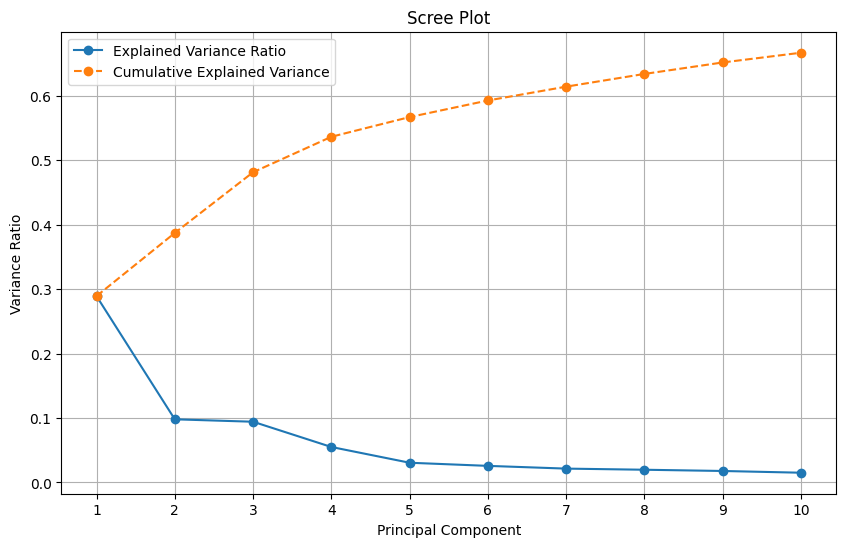

In [17]:
# Explained variance ratio
explained_variance_ratio = pca_elbow.explained_variance_ratio_

# Cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)


# Create a DataFrame for the explained variance
df_var = pd.DataFrame({
    'Component': np.arange(1, len(cumulative_explained_variance)+1),
    'Explained Variance Ratio': explained_variance_ratio,
    'Cumulative Explained Variance': cumulative_explained_variance
})

# Plot the Scree Plot
plt.figure(figsize=(10, 6))
plt.plot(df_var['Component'], df_var['Explained Variance Ratio'], marker='o', label='Explained Variance Ratio')
plt.plot(df_var['Component'], df_var['Cumulative Explained Variance'], marker='o', linestyle='--', label='Cumulative Explained Variance')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Ratio')
plt.xticks(np.arange(1, len(cumulative_explained_variance)+1))
plt.legend()
plt.grid()
plt.show()

In [18]:
## Kaiser criterion:
print(pca_elbow.explained_variance_[pca_elbow.explained_variance_ > 1])

[40.98614679 13.88906504 13.35509333  7.80055946  4.33543092  3.64680066
  3.04491438  2.79606203  2.52350363  2.1404299 ]


  - In this exercise, there's two technique I would like to use to identify how many Principal Components that we could keep:
    - Kaiser Criterion:
      - Determine which components have eigenvalues greater than 1. Count the number of such components to decide how many to keep
      - But all of ten components have explained_variance greater than 1 so we will not use this Criterion
    - Elbow Criterion:
      - Determine the number of PCs to keep depends on how much percentage each percentage contribute to the sum of all explained_variance
      - In this Scree plot, the 'elbow' point is at the PC 4 so we will take the first three PCs: PC 1, PC 2, PC 3 to continue analysis

## 3. Image Classification

The classification task will compare the performance using both:

- Original data: The data before applying PCA.
- Transformed data: The data projected onto the optimal number of principal components identified earlier. Utilize the **optimal number of principal components** identified in the previous question.

Compare the performance of **4** different classification algorithms (3 machine learning and 1 MLP models) in both formats above. (4 points)

Perform hyperparameter tuning using ```GridSearchCV``` for each classification method. (1 point)

Inspiration: Draw inspiration from the example provided in the scikit-learn documentation: https://scikit-learn.org/dev/auto_examples/datasets/plot_iris_dataset.html

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score


In [20]:
flattened_images.shape

(35887, 2304)

In [21]:
## splitting data into train/val/test subsets here
X_train, X_test, y_train, y_test = train_test_split(
    flattened_images, labels, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)


In [33]:
## split data fro Transformed data
df.columns = df.columns.astype(str)
trainX, testX, trainY, testY = train_test_split(
    df, labels, test_size=0.2, random_state=42)

trainX, valX, trainY, valY = train_test_split(
    trainX, trainY, test_size=0.2, random_state=42)

### **3.1. Logistic Regression**

In [23]:
def build_model_lr(X, y, GridSearch=False):
    # Define pipeline for Logistic Regression
    pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression())
    ])


    if GridSearch==False:
      pipe_lr.fit(X, y)
      return pipe_lr

    else:
      # Hyperparameters for GridSearchCV
      param_grid_lr = {
      'clf__C': [0.1, 1, 10],
      'clf__solver': ['liblinear']
      }

      # Perform GridSearchCV
      grid_lr = GridSearchCV(pipe_lr, param_grid_lr, cv=5, n_jobs=-1)
      grid_lr.fit(X, y)

      print("Best parameter (CV score=%0.3f):" % grid_lr.best_score_)
      print(grid_lr.best_params_)

      return grid_lr

#### Original data

In [24]:
# fit model
lr = build_model_lr(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [25]:
# training accuracy
y_pred = lr.predict(X_val)
acc_val_lr = accuracy_score(y_val, y_pred)
print(acc_val_lr)

0.3512713340299547


#### Transformed data

In [34]:
transformed_data_lr = build_model_lr(trainX, trainY)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [35]:
# output: pca_acc_val_lr
predY = transformed_data_lr.predict(valX)
pca_acc_val_lr = accuracy_score(valY, predY)
print(pca_acc_val_lr)

0.8507488679902473


### **3.2. Random Forest**

In [36]:
def build_model_rf(X, y, GridSearch=False):

    # Define pipeline for Random Forest
    pipe_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier())
    ])

    if GridSearch==False:
      pipe_rf.fit(X, y)
      return pipe_rf

    else:
      # Hyperparameters for GridSearchCV
      param_grid_rf = {
      'clf__n_estimators': [100, 200],
      'clf__max_depth': [None, 10, 20]
      }

      # Perform GridSearchCV
      grid_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=5, n_jobs=-1)
      grid_rf.fit(X, y)

      print("Best parameter (CV score=%0.3f):" % grid_rf.best_score_)
      print(grid_rf.best_params_)

      return grid_rf

#### Original data

In [37]:
# fit model
rf = build_model_rf(X_train, y_train)

In [38]:
# training accuracy
y_pred_rf = rf.predict(X_val)
acc_val_rf = accuracy_score(y_val, y_pred_rf)
print(acc_val_rf)

0.45332636711947055


#### Transformed data

In [39]:
transformed_data_rf = build_model_rf(trainX, trainY)

In [40]:
predY_rf = transformed_data_rf.predict(valX)
pca_acc_val_rf = accuracy_score(valY, predY_rf)
print(pca_acc_val_rf)

0.6664925113200976


### **3.3. SVM**

In [41]:
def build_model_svm(X, y, GridSearch=False):

    # Define pipeline for Random Forest
    pipe_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC())
    ])

    if GridSearch==False:
      pipe_svm.fit(X, y)
      return pipe_svm

    else:
      # Hyperparameters for GridSearchCV
      param_grid_svm = {
      'clf__C': [0.1, 1, 10, 100],
      'clf__kernel': ['linear', 'rbf']
      }

      # Perform GridSearchCV
      grid_svm = GridSearchCV(pipe_svm, param_grid_svm, cv=5, n_jobs=-1)
      grid_svm.fit(X, y)

      print("Best parameter (CV score=%0.3f):" % grid_svm.best_score_)
      print(grid_svm.best_params_)

      return grid_svm

#### Original data

In [ ]:
# fit model
svm = build_model_svm(X_train, y_train)

In [ ]:
# training accuracy
y_pred_svm = svm.predict(X_val)
acc_val_svm = accuracy_score(y_val, y_pred_svm)
print(acc_val_svm)

#### Transformed data

In [ ]:
transformed_data_svm = build_model_svm(trainX, trainY)

In [ ]:
predY_svm = transformed_data_svm.predict(valX)
pca_acc_val_svm = accuracy_score(valY, predY_svm)
print(pca_acc_val_svm)

### **3.4. MLP**

In [ ]:
def build_model_mlp(X, y, GridSearch=False):

    # Define pipeline for Random Forest
    pipe_mlp = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', MLPClassifier())
    ])

    if GridSearch==False:
      pipe_mlp.fit(X, y)
      return pipe_mlp

    else:
      # Hyperparameters for GridSearchCV
      param_grid_mlp = {
      'clf__hidden_layer_sizes': [(100,), (100, 100)],
      'clf__activation': ['relu', 'tanh'],
      'clf__solver': ['adam'],
      'clf__alpha': [0.0001, 0.001]
      }

      # Perform GridSearchCV
      grid_mlp = GridSearchCV(pipe_mlp, param_grid_mlp, cv=5, n_jobs=-1)
      grid_mlp.fit(X, y)

      print("Best parameter (CV score=%0.3f):" % grid_mlp.best_score_)
      print(grid_mlp.best_params_)

      return grid_mlp

#### Original data

In [ ]:
# fit model
mlp = build_model_mlp(X_train, y_train)

In [ ]:
# training accuracy
y_pred_mlp = lr.predict(X_val)
acc_val_mlp = accuracy_score(y_val, y_pred_mlp)
print(acc_val_mlp)

#### Transformed data

In [ ]:
transformed_data_mlp = build_model_mlp(trainX, trainY)

In [ ]:
predY_mlp = transformed_data_mlp.predict(valX)
pca_acc_val_mlp = accuracy_score(valY, predY_mlp)
print(pca_acc_val_mlp)

### Compare the performance on val set

In [ ]:
from tabulate import tabulate

data_header = ['Model with', 'Original data', 'Transformed data']
data_values = [
      ['Logistic Regression', acc_val_lr, pca_acc_val_lr],
      ['Random Forest', acc_val_rf, pca_acc_val_rf],
      ['SVM', acc_val_svm, pca_acc_val_svm],
      ['MLP', acc_val_mlp, pca_acc_val_mlp]
]

In [ ]:
# Generate the table
result = tabulate(
data_values,
headers=data_header,
tablefmt='fancy_grid',
)
# Print the resulting table
print(result)


In [ ]:
# images_pca=pca.transform(images) ## modify images' array to the appropriate shape

## 4. Evaluating Classification Performance

Compare the performance of the different classification models using various metrics: accuracy, precision, recall, and F1-score.
Based on the evaluation metrics, explain which model performs best and why. Identify the emotion category where the model makes the most accurate and most errors. (1 point)



In [ ]:
## visualize the confusion matrices and classification reports here